In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from PIL import Image
import numpy as np
from io import BytesIO
import os

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
import requests
import numpy as np
import librosa
from tqdm import tqdm
import os

from IPython.display import Audio


In [2]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_19376\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [3]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [4]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [5]:
bp_genre.head()

,genre_id,genre_name,song_count,genre_url,updated_on
0,8,Hard Dance / Hardcore,178646,/genre/hard-dance-hardcore/8,2023-09-19 15:01:03
1,50,Nu Disco / Disco,157934,/genre/nu-disco-disco/50,2023-09-19 15:01:03
2,12,Deep House,897280,/genre/deep-house/12,2023-09-19 15:01:03
3,85,Bass / Club,20716,/genre/bass-club/85,2023-09-19 15:01:03
4,94,Electro (Classic / Detroit / Modern),19615,/genre/electro-classic-detroit-modern/94,2023-09-19 15:01:03


In [6]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

# Display the first few rows to verify
bp_media.head()

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [7]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [9]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [17]:
import os
import requests
from tqdm import tqdm

def load_audio_from_url(df, sample_uuid_column, n_mfcc=13, max_length=200):
    audio_features = []
    failed_samples = []  # List to store IDs of failed audio downloads
    saved_file_paths = []  # List to collect the paths of saved audio files
    
    base_url = "https://geo-samples.beatport.com/track/"  # Base URL for audio files
    save_directory = "audio_files"  # Directory to save downloaded audio
    os.makedirs(save_directory, exist_ok=True)
    
    for sample_uuid in tqdm(df[sample_uuid_column]):
        # Construct full audio URL
        audio_url = f"{base_url}{sample_uuid}.LOFI.mp3"
        save_path = os.path.join(save_directory, f"{sample_uuid}.mp3")
        
        try:
            # Send a request to download the audio file
            response = requests.get(audio_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Save the downloaded audio file locally
            with open(save_path, 'wb') as f:
                f.write(response.content)
            
            # Append the file path to the saved file paths list
            saved_file_paths.append(save_path)
        
        except Exception as e:
            print(f"Error loading audio {sample_uuid}: {e}")
            failed_samples.append(sample_uuid)  # Add the sample_uuid to the failed list
    
    return saved_file_paths, failed_samples

In [18]:
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

 13%|█▎        | 132/1000 [00:40<03:54,  3.69it/s]

Error loading audio a0196b91-79b3-47c8-9e51-282acaa13963: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a0196b91-79b3-47c8-9e51-282acaa13963.LOFI.mp3


 20%|██        | 201/1000 [01:02<03:52,  3.44it/s]

Error loading audio a8b326ce-95af-4a23-83d5-ebec83c4952b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a8b326ce-95af-4a23-83d5-ebec83c4952b.LOFI.mp3


 44%|████▍     | 440/1000 [02:25<03:12,  2.91it/s]

Error loading audio 77c54e71-ed31-4d8e-9474-f8b7fd555a0d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/77c54e71-ed31-4d8e-9474-f8b7fd555a0d.LOFI.mp3


 67%|██████▋   | 666/1000 [03:55<02:05,  2.66it/s]

Error loading audio 485662be-e550-4b98-8d8f-5634e292da1a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/485662be-e550-4b98-8d8f-5634e292da1a.LOFI.mp3


 73%|███████▎  | 727/1000 [04:20<01:45,  2.58it/s]

Error loading audio c517223d-457d-488e-8e6e-3b5016fc3f7b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c517223d-457d-488e-8e6e-3b5016fc3f7b.LOFI.mp3


 74%|███████▍  | 742/1000 [04:26<01:36,  2.66it/s]

Error loading audio d1e1683c-7f74-432e-854a-fdda91faf169: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d1e1683c-7f74-432e-854a-fdda91faf169.LOFI.mp3


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


In [19]:
# Function to extract MFCCs from an audio file
def extract_mfcc(audio_file_path, n_mfcc=13, max_length=200):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCCs to a fixed length
        if mfccs.shape[1] < max_length:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs_padded = mfccs[:, :max_length]

        return mfccs_padded
    
    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [20]:
# Initialize lists to hold MFCC features and genres
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'genre_name'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")

  0%|          | 0/994 [00:00<?, ?it/s]

100%|██████████| 994/994 [06:06<00:00,  2.71it/s]


Extracted MFCC features shape: (994, 13, 200)
Genre labels shape: (994,)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Normalize the MFCC features
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

# 2. Convert genre labels to numerical format (if they are strings)
# This step assumes that genres are strings. If they are already numbers, you can skip it.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 200), (795, 30)
Test set shape: (199, 13, 200), (199, 30)


In [22]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 198, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 99, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 97, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 48, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               3

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio.h5'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/100
53/53 [==============================] - 2s 19ms/step - loss: 3.1521 - accuracy: 0.1107 - val_loss: 2.9454 - val_accuracy: 0.1307 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 1s 10ms/step - loss: 2.9576 - accuracy: 0.1220 - val_loss: 2.8590 - val_accuracy: 0.1759 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 0s 8ms/step - loss: 2.8442 - accuracy: 0.1635 - val_loss: 2.9203 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 0s 8ms/step - loss: 2.7571 - accuracy: 0.1799 - val_loss: 2.9248 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 2.6827 - accuracy: 0.2050 - val_loss: 2.8676 - val_accuracy: 0.1156 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 0s 7ms/step - loss: 2.5440 - accuracy: 0.2491 - val_loss: 2.8636 - val_accuracy: 0.1809 - lr: 0.0010
Epoch 7/100
53/53 [==============================] - 0s 8ms/step - loss: 2

_________

# Manual Grouping

In [24]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [25]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

# Check the result
print(bp_genre[['genre_name', 'broad_genre']])

                              genre_name            broad_genre
0                  Hard Dance / Hardcore  Hard Dance & Hardcore
1                       Nu Disco / Disco              Dance/Pop
2                             Deep House                  House
3                            Bass / Club             Bass Music
4   Electro (Classic / Detroit / Modern)   Experimental & Indie
5                            Hard Techno                 Techno
6                                Dubstep             Bass Music
7             140 / Deep Dubstep / Grime             Bass Music
8                            Funky House                  House
9                      Progressive House                  House
10             Organic House / Downtempo      Downtempo & World
11                           Indie Dance   Experimental & Indie
12                            Afro House                  House
13                   Minimal / Deep Tech                 Techno
14                             Mainstage

In [27]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

In [28]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [30]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [31]:
# Initialize lists to hold MFCC features and genres
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'broad_genre'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")


100%|██████████| 994/994 [05:53<00:00,  2.81it/s]


Extracted MFCC features shape: (994, 13, 200)
Genre labels shape: (994,)


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Normalize the MFCC features
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

In [33]:
# 2. Convert genre labels to numerical format (if they are strings)
# This step assumes that genres are strings. If they are already numbers, you can skip it.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 200), (795, 8)
Test set shape: (199, 13, 200), (199, 8)


In [34]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 11, 198, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 99, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 97, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 48, 64)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio.h5'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/100
53/53 [==============================] - 1s 15ms/step - loss: 1.8265 - accuracy: 0.3057 - val_loss: 1.7328 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 1s 13ms/step - loss: 1.7394 - accuracy: 0.3358 - val_loss: 1.7115 - val_accuracy: 0.3769 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 1s 18ms/step - loss: 1.6787 - accuracy: 0.3459 - val_loss: 1.6927 - val_accuracy: 0.3769 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 0s 8ms/step - loss: 1.6152 - accuracy: 0.3673 - val_loss: 1.7010 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 1.6004 - accuracy: 0.3736 - val_loss: 1.7141 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 0s 8ms/step - loss: 1.5538 - accuracy: 0.3836 - val_loss: 1.7299 - val_accuracy: 0.3769 - lr: 0.0010
Epoch 7/100
53/53 [==============================] - 0s 8ms/step - loss: 

______________

# KMeans Clustering

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [37]:
sampled_data = bp_media.sample(n=1000, random_state=42)

saved_file_paths, failed_samples_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

 13%|█▎        | 132/1000 [01:03<10:01,  1.44it/s]

Error loading audio a0196b91-79b3-47c8-9e51-282acaa13963: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a0196b91-79b3-47c8-9e51-282acaa13963.LOFI.mp3


 20%|██        | 201/1000 [01:29<04:19,  3.08it/s]

Error loading audio a8b326ce-95af-4a23-83d5-ebec83c4952b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a8b326ce-95af-4a23-83d5-ebec83c4952b.LOFI.mp3


 44%|████▍     | 440/1000 [03:10<03:31,  2.65it/s]

Error loading audio 77c54e71-ed31-4d8e-9474-f8b7fd555a0d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/77c54e71-ed31-4d8e-9474-f8b7fd555a0d.LOFI.mp3


 67%|██████▋   | 666/1000 [04:45<02:55,  1.91it/s]

Error loading audio 485662be-e550-4b98-8d8f-5634e292da1a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/485662be-e550-4b98-8d8f-5634e292da1a.LOFI.mp3


 73%|███████▎  | 727/1000 [05:18<02:45,  1.65it/s]

Error loading audio c517223d-457d-488e-8e6e-3b5016fc3f7b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c517223d-457d-488e-8e6e-3b5016fc3f7b.LOFI.mp3


 74%|███████▍  | 742/1000 [05:27<02:57,  1.45it/s]

Error loading audio d1e1683c-7f74-432e-854a-fdda91faf169: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d1e1683c-7f74-432e-854a-fdda91faf169.LOFI.mp3


100%|██████████| 1000/1000 [07:50<00:00,  2.12it/s]


In [40]:
def extract_mfcc(audio_file_path, n_mfcc=13, max_length=200):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCC to a fixed length
        if mfccs.shape[1] < max_length:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs_padded = mfccs[:, :max_length]
        
        # Flatten the MFCCs to 1D
        return mfccs_padded.flatten()

    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [41]:
features_list = []
for audio_file_path in saved_file_paths:
    mfcc_features = extract_mfcc(audio_file_path)  # Using your extract_mfcc function
    features_list.append(mfcc_features)

# Convert features list to a numpy array for clustering
features_list = np.array(features_list)

In [42]:
scaler = StandardScaler()
features_list_scaled = scaler.fit_transform(features_list)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

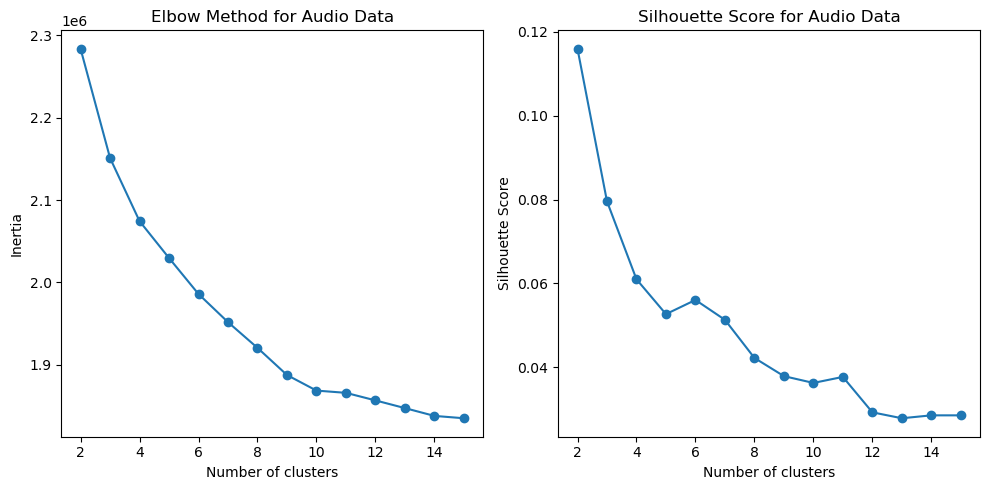

In [43]:
inertia = []
sil_scores = []
cluster_range = range(2, 16)  # Test 2 to 15 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_list_scaled)
    
    # Append the inertia for Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Predict cluster labels and calculate silhouette score
    cluster_labels = kmeans.predict(features_list_scaled)
    sil_score = silhouette_score(features_list_scaled, cluster_labels)
    sil_scores.append(sil_score)

# Step 5: Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(10, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Audio Data')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Audio Data')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


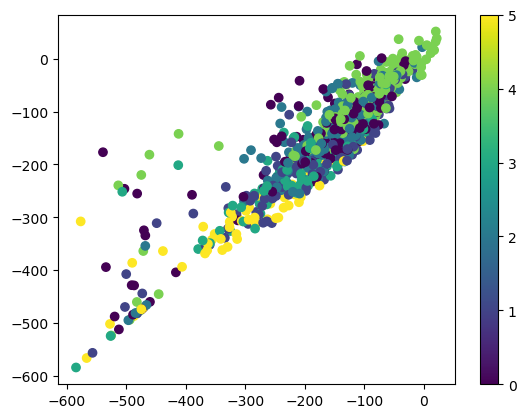

In [44]:
# Assuming 'features_list' is a list of feature vectors for all images
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(features_list)

# Visualize or check cluster assignments
plt.scatter(features_list[:, 0], features_list[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.show()